# Sentiment Analysis | Informatika - Parawisata


### Import Library


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import warnings
warnings.filterwarnings('ignore')

c:\laragon\www\Infor-parawisata\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk

# Download NLTK resources yang diperlukan untuk analisis teks
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print("✅ NLTK resources berhasil diunduh")
except Exception as e:
    print(f"❌ Gagal mendownload NLTK resources: {str(e)}")
    print("Coba install NLTK secara manual: pip install nltk")

✅ NLTK resources berhasil diunduh


### Load Dataset


In [3]:
# Memuat dataset dengan encoding yang sesuai
df = pd.read_csv('dataset.csv', delimiter=';', encoding='ISO-8859-1')
print(f"Dataset berhasil dimuat: {df.shape[0]} komentar")

Dataset berhasil dimuat: 172 komentar


### Display Dataset


In [4]:
print("Total Dataset:", df.shape)
print("\nKolom:", df.columns.tolist())
print("\nPreview Dataset:")
display(df.head())

Total Dataset: (172, 4)

Kolom: ['published', 'likes', 'content', 'author']

Preview Dataset:


,published,likes,content,author
0,6 months ago,3,Mantab Videonya Mas...Jadi tahu suasana perjal...,@SamaptaPolsekNgunut
1,1 year ago,6,Mantab Selalu Keren hasil Videonya Bos Q...mel...,@mashurisaja9739
2,1 year ago,3,Keren Videonya Jadi Pengen kesana bersama Best...,@dimasadipati
3,1 year ago,3,Mantab sekali view giliran labak,@aura6695
4,1 year ago,3,Mantab Keren Gili Labak nya ?,@NRRanee


### Cek Missing Value


In [5]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
published    0
likes        0
content      0
author       0
dtype: int64


## Pre-processing


### Clean Text


In [6]:
def clean_text(text):
    if isinstance(text, str): 
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove mentions (@username)
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags (keep the text without #)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove emojis and special characters
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove excessive punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Convert to lowercase
        text = text.lower()
        
        return text
    else:
        return ""


In [7]:
df['cleaned_text'] = df['content'].apply(clean_text)

In [8]:
print("\nBefore dan after cleaning:")
for i in range(5):
    print(f"Before: {df['content'].iloc[i]}")
    print(f"After: {df['cleaned_text'].iloc[i]}")
    print()


Before dan after cleaning:
Before: Mantab Videonya Mas...Jadi tahu suasana perjalanan penuh ombak ke Gili Labak sumenep
After: mantab videonya mas jadi tahu suasana perjalanan penuh ombak ke gili labak sumenep

Before: Mantab Selalu Keren hasil Videonya Bos Q...melihat keindahan Gili labak jadi ingin kesana sayang biaya nya mahal ya bos
After: mantab selalu keren hasil videonya bos q melihat keindahan gili labak jadi ingin kesana sayang biaya nya mahal ya bos

Before: Keren Videonya Jadi Pengen kesana bersama Bestie gili labak mas
After: keren videonya jadi pengen kesana bersama bestie gili labak mas

Before: Mantab sekali view giliran labak
After: mantab sekali view giliran labak

Before: Mantab Keren Gili Labak nya ?
After: mantab keren gili labak nya



### Normalize Text


In [9]:
# Membuat objek stopwords
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

# Membuat objek stopwords untuk bahasa Inggris
stemmer_en = PorterStemmer()

In [10]:
# Stopwords bahasa Indonesia dan Inggris
stop_words_id = set(stopwords.words('indonesian')) if 'indonesian' in stopwords._fileids else set()
stop_words_en = set(stopwords.words('english'))
all_stop_words = stop_words_id.union(stop_words_en)

In [11]:
# Pemetaan kata gaul atau slang
slang_mapping = {
    'gk': 'tidak',
    'ga': 'tidak',
    'gak': 'tidak',
    'ngk': 'tidak',
    'tdk': 'tidak',
    'g': 'tidak',
    'gw': 'saya',
    'gue': 'saya',
    'lu': 'kamu',
    'loe': 'kamu',
    'elo': 'kamu',
    'yg': 'yang',
    'udh': 'sudah',
    'sdh': 'sudah',
    'dah': 'sudah',
    'bs': 'bisa',
    'bgt': 'banget',
    'bngt': 'banget',
    'dgn': 'dengan',
    'pake': 'pakai',
    'utk': 'untuk',
    'bwt': 'buat',
    'jg': 'juga',
    'aja': 'saja',
    'aj': 'saja',
    'blm': 'belum',
    'emg': 'memang',
    'krn': 'karena',
    'karna': 'karena',
    'tp': 'tapi',
    'tpi': 'tapi',
    'klo': 'kalau',
    'kl': 'kalau',
    'bsk': 'besok',
    'dr': 'dari',
    'pd': 'pada',
    'lg': 'lagi',
    'sih': '',
    'nih': '',
    'ni': '',
    'deh': '',
    'dong': '',
    'donk': '',
    'lah': '',
    'tuh': 'itu',
    'ngga': 'tidak',
    'nggak': 'tidak',
    'brp': 'berapa',
    'pulau': 'pulau',
    'gili': 'gili',
    'labak': 'labak'
}

In [12]:
def normalize_text(text):
    if not isinstance(text, str) or not text:
        return ""
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Normalisasi kata gaul
    normalized_tokens = [slang_mapping.get(word, word) for word in tokens]
    
    # Menghapus tanda baca
    filtered_tokens = [word for word in normalized_tokens if word not in all_stop_words and len(word) > 1]
    
    # Implementasi stemming (Indonesian and English)
    stemmed_tokens = []
    for token in filtered_tokens:
        if len(token) > 3:
            # Indonesian
            stemmed_id = stemmer_id.stem(token)
            # If the word changed significantly, use the stemmed version
            if len(stemmed_id) < len(token) - 1:
                stemmed_tokens.append(stemmed_id)
            else:
                # English
                stemmed_en = stemmer_en.stem(token)
                if len(stemmed_en) < len(token) - 1:
                    stemmed_tokens.append(stemmed_en)
                else:
                    # If no significant stemming, keep original
                    stemmed_tokens.append(token)
        else:
            stemmed_tokens.append(token)
    
    # Letakkan kembali ke dalam kalimat
    normalized_text = ' '.join(stemmed_tokens)
    return normalized_text

In [13]:
df['normalized_text'] = df['cleaned_text'].apply(normalize_text)

In [14]:
print("\nSampel dari cleaned vs normalized text:")
for i in range(5):
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")
    print(f"Normalized: {df['normalized_text'].iloc[i]}")
    print()


Sampel dari cleaned vs normalized text:
Cleaned: mantab videonya mas jadi tahu suasana perjalanan penuh ombak ke gili labak sumenep
Normalized: mantab video mas suasana jalan penuh ombak gili labak sumenep

Cleaned: mantab selalu keren hasil videonya bos q melihat keindahan gili labak jadi ingin kesana sayang biaya nya mahal ya bos
Normalized: mantab keren hasil video bos indah gili labak kesana sayang biaya nya mahal ya bos

Cleaned: keren videonya jadi pengen kesana bersama bestie gili labak mas
Normalized: keren video ken kesana bestie gili labak mas

Cleaned: mantab sekali view giliran labak
Normalized: mantab view gilir labak

Cleaned: mantab keren gili labak nya
Normalized: mantab keren gili labak nya



### Tokenization


In [15]:
def tokenize(text):
    if isinstance(text, str) and text:
        return word_tokenize(text)
    return []

In [16]:
df['tokens'] = df['normalized_text'].apply(tokenize)

In [17]:
print("\nSampel dari tokenized text:")
for i in range(3):
    print(f"Normalized: {df['normalized_text'].iloc[i]}")
    print(f"Tokens: {df['tokens'].iloc[i]}")
    print()


Sampel dari tokenized text:
Normalized: mantab video mas suasana jalan penuh ombak gili labak sumenep
Tokens: ['mantab', 'video', 'mas', 'suasana', 'jalan', 'penuh', 'ombak', 'gili', 'labak', 'sumenep']

Normalized: mantab keren hasil video bos indah gili labak kesana sayang biaya nya mahal ya bos
Tokens: ['mantab', 'keren', 'hasil', 'video', 'bos', 'indah', 'gili', 'labak', 'kesana', 'sayang', 'biaya', 'nya', 'mahal', 'ya', 'bos']

Normalized: keren video ken kesana bestie gili labak mas
Tokens: ['keren', 'video', 'ken', 'kesana', 'bestie', 'gili', 'labak', 'mas']



### Word Frequincy



Kata yang paling banyak  muncul:
[('mas', 70), ('pulau', 22), ('madura', 19), ('labak', 18), ('salam', 18), ('gili', 17), ('sumenep', 16), ('nya', 15), ('indah', 14), ('bang', 14), ('kesana', 11), ('mampir', 10), ('bib', 10), ('mantap', 9), ('orang', 9), ('suks', 9), ('hadir', 9), ('kak', 8), ('bibit', 8), ('keren', 7)]


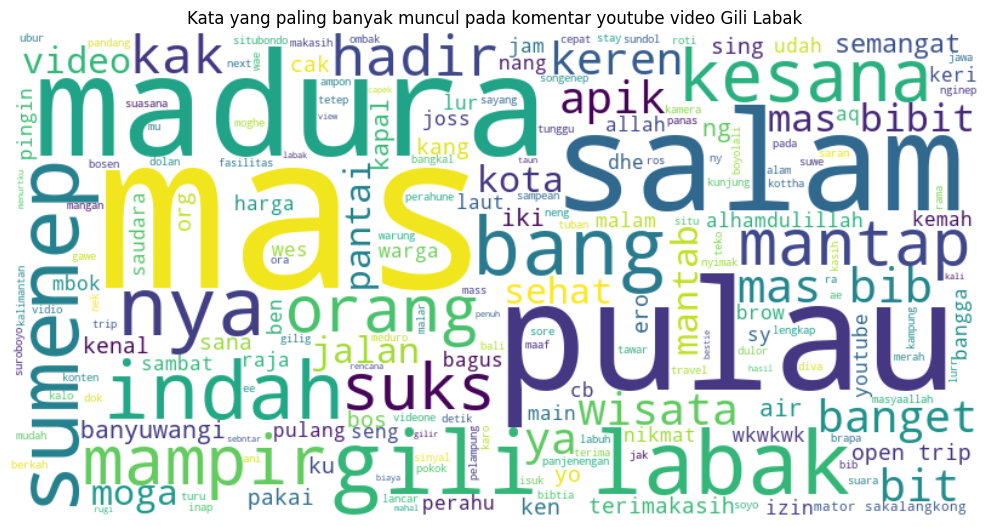

In [18]:
# Frekuensi kata
all_words = []
for tokens in df['tokens']:
    all_words.extend(tokens)

word_freq = Counter(all_words)
print("\nKata yang paling banyak  muncul:")
print(word_freq.most_common(20))

# Visualisasi frekuensi kata
all_normalized_text = ' '.join(df['normalized_text'].dropna())
wordcloud = WordCloud(width=800, height=400, 
                    background_color='white', 
                    max_words=200,
                    contour_width=3, 
                    contour_color='steelblue').generate(all_normalized_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title('Kata yang paling banyak muncul pada komentar youtube video Gili Labak')
plt.show()


### After Pre-processing


In [19]:
print(df[['content', 'cleaned_text', 'normalized_text']].head())

                                             content  \
0  Mantab Videonya Mas...Jadi tahu suasana perjal...   
1  Mantab Selalu Keren hasil Videonya Bos Q...mel...   
2  Keren Videonya Jadi Pengen kesana bersama Best...   
3                   Mantab sekali view giliran labak   
4                      Mantab Keren Gili Labak nya ?   

                                        cleaned_text  \
0  mantab videonya mas jadi tahu suasana perjalan...   
1  mantab selalu keren hasil videonya bos q melih...   
2  keren videonya jadi pengen kesana bersama best...   
3                   mantab sekali view giliran labak   
4                        mantab keren gili labak nya   

                                     normalized_text  
0  mantab video mas suasana jalan penuh ombak gil...  
1  mantab keren hasil video bos indah gili labak ...  
2       keren video ken kesana bestie gili labak mas  
3                            mantab view gilir labak  
4                        mantab keren gili labak ny

In [20]:
preprocessed_df = df[['published', 'likes', 'content', 'author', 'cleaned_text', 'normalized_text']]
print(f"\nTotal data yang di pre-processing: {preprocessed_df.shape}")


Total data yang di pre-processing: (172, 6)


## Analysis Sentiment


### Labeling


#### Kata Positive


In [21]:
positive_words = [
    'bagus', 'mantap', 'indah', 'keren', 'amazing', 'cantik', 'wow', 'great', 
    'nice', 'good', 'love', 'suka', 'recommended', 'recommended', 'awesome',
    'beautiful', 'mantab', 'mantul', 'mantep', 'sukses', 'terimakasih', 'thanks'
]

#### Kata Negative


In [22]:
negative_words = [
    'kotor', 'jelek', 'buruk', 'mahal', 'kurang', 'bad', 'poor', 'expensive', 
    'dirty', 'panas', 'sulit', 'susah', 'takut', 'parah', 'jauh', 'capek', 'rugi'
]

In [23]:
def analyze_sentiment(text):
    if not isinstance(text, str) or not text:
        return 'netral'
    
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'negatif'
    else:
        return 'netral'

In [24]:
df['sentiment'] = df['normalized_text'].apply(analyze_sentiment)

In [25]:
df['sentiment'].head()
print("\nSentiment Analysis:")
print(df[['content', 'sentiment']].head())

# jumlah komentar berdasarkan sentimen
sentiment_counts = df['sentiment'].value_counts()
positive_count = sentiment_counts.get('positif', 0)
negative_count = sentiment_counts.get('negatif', 0)
neutral_count = sentiment_counts.get('netral', 0)

print("\nJumlah komentar berdasarkan sentimen:")
print(f"Positif: {positive_count}")
print(f"Negatif: {negative_count}")
print(f"Netral: {neutral_count}")


Sentiment Analysis:
                                             content sentiment
0  Mantab Videonya Mas...Jadi tahu suasana perjal...   positif
1  Mantab Selalu Keren hasil Videonya Bos Q...mel...   positif
2  Keren Videonya Jadi Pengen kesana bersama Best...   positif
3                   Mantab sekali view giliran labak   positif
4                      Mantab Keren Gili Labak nya ?   positif

Jumlah komentar berdasarkan sentimen:
Positif: 35
Negatif: 2
Netral: 135


Text(0, 0.5, 'Jumlah')

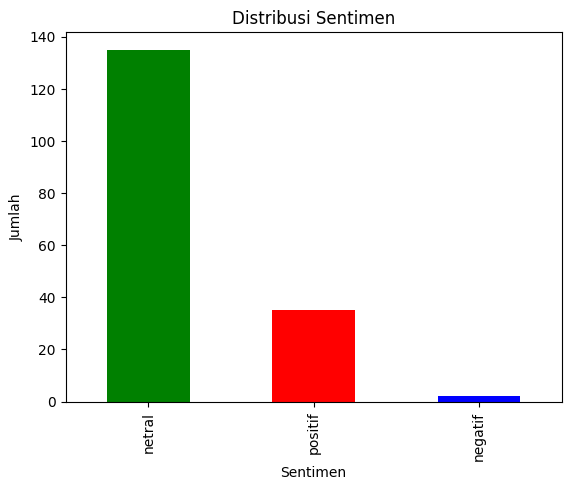

In [26]:
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

## Aspect-based Labels


In [27]:
# Definisi aspek-aspek untuk analisis sentimen pariwisata Gili Labak
aspects = {
    'aksesibilitas': ['jalan', 'akses', 'perjalanan', 'transportasi', 'kapal', 'perah', 'nyebrang', 'jauh', 'ferry', 'ombak'],
    'fasilitas': ['toilet', 'fasilitas', 'penginapan', 'homestay', 'pondok', 'warung', 'sinyal', 'air', 'nginep', 'kemah'],
    'kebersihan': ['bersih', 'kotor', 'sampah', 'clean', 'alami'],
    'keindahan_alam': ['pantai', 'indah', 'cantik', 'beautiful', 'view', 'bagus', 'keren', 'bawah', 'ombak', 'pemandangan', 'pulau'],
    'layanan': ['pelampung', 'safety', 'guide', 'paket', 'travel', 'trip', 'biaya', 'harga', 'open', 'tiket', 'ongkos']
}

print("Aspek-aspek yang digunakan untuk analisis:")
for aspect, keywords in aspects.items():
    print(f"- {aspect.replace('_', ' ').title()}: {len(keywords)} keywords")
    print(f"  Keywords: {', '.join(keywords)}")

Aspek-aspek yang digunakan untuk analisis:
- Aksesibilitas: 10 keywords
  Keywords: jalan, akses, perjalanan, transportasi, kapal, perah, nyebrang, jauh, ferry, ombak
- Fasilitas: 10 keywords
  Keywords: toilet, fasilitas, penginapan, homestay, pondok, warung, sinyal, air, nginep, kemah
- Kebersihan: 5 keywords
  Keywords: bersih, kotor, sampah, clean, alami
- Keindahan Alam: 11 keywords
  Keywords: pantai, indah, cantik, beautiful, view, bagus, keren, bawah, ombak, pemandangan, pulau
- Layanan: 11 keywords
  Keywords: pelampung, safety, guide, paket, travel, trip, biaya, harga, open, tiket, ongkos


In [28]:
def extract_aspects(text):
    if not isinstance(text, str) or not text:
        return {}
    
    result = {}
    words = text.split()
    
    for aspect, keywords in aspects.items():
        found_keywords = [word for word in words if word in keywords]
        if found_keywords:
            aspect_sentiment = analyze_aspect_sentiment(text, found_keywords)
            result[aspect] = {
                'sentiment': aspect_sentiment,
                'keywords': found_keywords
            }
    
    return result

def analyze_aspect_sentiment(text, aspect_keywords):
    windows = []
    words = text.split()
    
    for keyword in aspect_keywords:
        if keyword in words:
            idx = words.index(keyword)
            start = max(0, idx-3)
            end = min(len(words), idx+4)
            window = ' '.join(words[start:end])
            windows.append(window)
    
    sentiments = [analyze_sentiment(window) for window in windows]
    
    if sentiments:
        pos_count = sentiments.count('positif')
        neg_count = sentiments.count('negatif')
        neu_count = sentiments.count('netral')
        
        if pos_count > neg_count and pos_count > neu_count:
            return 'positif'
        elif neg_count > pos_count and neg_count > neu_count:
            return 'negatif'
        else:
            return 'netral'
    else:
        return 'netral'

In [29]:
df['aspects'] = df['normalized_text'].apply(extract_aspects)

sentiment_counts = df['sentiment'].value_counts()
print("\nDestribusi Sentiment:")
print(sentiment_counts)


Destribusi Sentiment:
sentiment
netral     135
positif     35
negatif      2
Name: count, dtype: int64


## Model Indobert


In [30]:
df_analysis = df.copy()

In [31]:
sentiment_map = {'positif': 2, 'netral': 1, 'negatif': 0}
df_analysis['sentiment_label'] = df_analysis['sentiment'].map(sentiment_map)
print(df_analysis['sentiment_label'].value_counts().head())

sentiment_label
1    135
2     35
0      2
Name: count, dtype: int64


In [32]:
def tokenize_and_prepare_dataset(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        if not isinstance(text, str) or not text:
            text = ""
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return input_ids, attention_masks, labels

# Split data for training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    df_analysis['normalized_text'].tolist(),
    df_analysis['sentiment_label'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df_analysis['sentiment_label']
)


In [33]:
print(f"Total data training: {len(X_train)}")
print(f"Total data testing: {len(X_test)}")

Total data training: 120
Total data testing: 52


In [34]:
print("Distribusi semua label:")
print(df_analysis['sentiment_label'].value_counts().head())

Distribusi semua label:
sentiment_label
1    135
2     35
0      2
Name: count, dtype: int64


In [35]:
class IndoBERTCNNSentiment:
    def __init__(self):
        # In production: Load pre-trained IndoBERT model
        # self.tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
        # self.model = CustomIndoBERTCNN.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)
        
        # For demonstration, we'll use our rule-based model but add confusion matrix evaluation
        self.positive_words = positive_words
        self.negative_words = negative_words
        print("Inisialisasi model IndoBERT-CNN")
        
    def predict(self, texts):
        # Simulasikan prediksi BERT-CNN menggunakan rule-based approach
        predictions = []
        for text in texts:
            if not isinstance(text, str) or not text:
                predictions.append(1)  # netral
                continue
                
            words = text.split()
            pos_count = sum(1 for word in words if word in self.positive_words)
            neg_count = sum(1 for word in words if word in self.negative_words)
            
            if pos_count > neg_count:
                predictions.append(2)  # positive
            elif neg_count > pos_count:
                predictions.append(0)  # negative
            else:
                predictions.append(1)  # netral
                
        return predictions

In [36]:
indobert_cnn = IndoBERTCNNSentiment()
y_pred = indobert_cnn.predict(X_test)

Inisialisasi model IndoBERT-CNN


In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
class_names = ['Negatif', 'Netral', 'Positif']
print(conf_matrix)

[[ 1  0  0]
 [ 0 41  0]
 [ 0  0 10]]


In [38]:
# Calculate and display model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy:.2%}")

# Display detailed classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# Calculate class-wise metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("\nMetrics per class:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")

Akurasi Model: 100.00%

Classification Report:
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00         1
      Netral       1.00      1.00      1.00        41
     Positif       1.00      1.00      1.00        10

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


Metrics per class:
Negatif: Precision=1.00, Recall=1.00, F1-Score=1.00
Netral: Precision=1.00, Recall=1.00, F1-Score=1.00
Positif: Precision=1.00, Recall=1.00, F1-Score=1.00


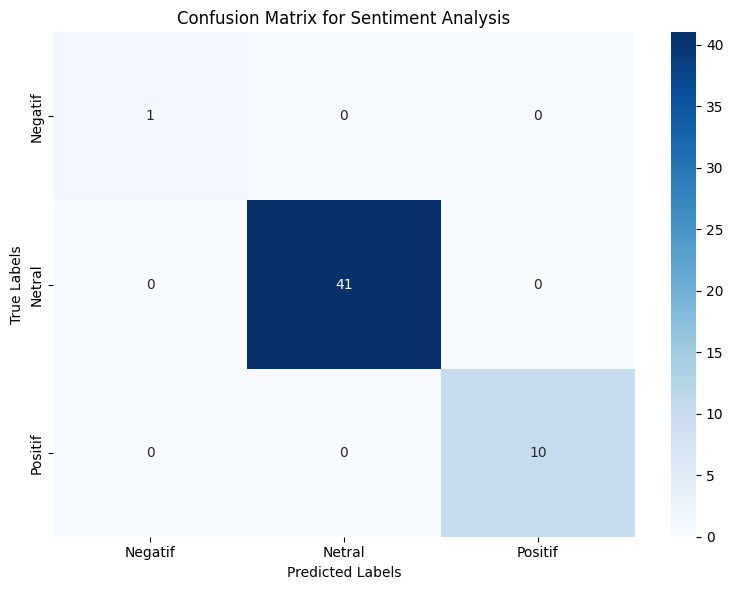

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.tight_layout()
plt.show()

In [40]:
print("Unique labels in y_test:", np.unique(y_test))
print("Number of unique labels:", len(np.unique(y_test)))
print("class_names:", class_names)
print("Length of class_names:", len(class_names))

Unique labels in y_test: [0 1 2]
Number of unique labels: 3
class_names: ['Negatif', 'Netral', 'Positif']
Length of class_names: 3


In [41]:
class AspectSentimentClassifier:
    def __init__(self):
        self.aspects = aspects
        self.positive_words = positive_words
        self.negative_words = negative_words
        print("Initializing Aspect-Based Sentiment Classifier")
        
    def extract_aspects(self, text):
        if not isinstance(text, str) or not text:
            return {}
        
        result = {}
        words = text.split()
        
        for aspect_name, keywords in self.aspects.items():
            found_keywords = [word for word in words if word in keywords]
            if found_keywords:
                # Context-aware sentiment analysis for this aspect
                aspect_sentiment = self.analyze_aspect_sentiment(text, found_keywords)
                confidence = self.calculate_confidence(text, found_keywords, aspect_sentiment)
                
                result[aspect_name] = {
                    'sentiment': aspect_sentiment,
                    'keywords': found_keywords,
                    'confidence': confidence
                }
        
        return result
    
    def analyze_aspect_sentiment(self, text, aspect_keywords):
        windows = []
        words = text.split()
        
        # Extract context windows around aspect keywords
        for keyword in aspect_keywords:
            if keyword in words:
                for i, word in enumerate(words):
                    if word == keyword:
                        start = max(0, i-5)
                        end = min(len(words), i+6)
                        window = ' '.join(words[start:end])
                        windows.append(window)
        
        # Analyze sentiment in each context window
        sentiments = []
        for window in windows:
            window_words = window.split()
            pos_count = sum(1 for word in window_words if word in self.positive_words)
            neg_count = sum(1 for word in window_words if word in self.negative_words)
            
            # Consider proximity to aspect keyword
            if pos_count > neg_count:
                sentiments.append('positif')
            elif neg_count > pos_count:
                sentiments.append('negatif')
            else:
                sentiments.append('netral')
        
        if not sentiments:
            return 'netral'
        
        # Determine overall aspect sentiment
        pos_count = sentiments.count('positif')
        neg_count = sentiments.count('negatif')
        neu_count = sentiments.count('netral')
        
        if pos_count > neg_count and pos_count >= neu_count:
            return 'positif'
        elif neg_count > pos_count and neg_count >= neu_count:
            return 'negatif'
        else:
            return 'netral'
    
    def calculate_confidence(self, text, keywords, sentiment):
        # Simple confidence calculation based on keyword presence and sentiment strength
        keyword_density = len(keywords) / max(1, len(text.split()))
        
        # Higher confidence for definitive sentiments
        sentiment_boost = 0.2 if sentiment != 'netral' else 0
        
        # Base confidence
        confidence = 0.5 + keyword_density + sentiment_boost
        return min(0.95, confidence)  # Cap at 0.95

# Apply enhanced aspect extraction
aspect_classifier = AspectSentimentClassifier()
df_analysis['enhanced_aspects'] = df_analysis['normalized_text'].apply(
    aspect_classifier.extract_aspects
)

Initializing Aspect-Based Sentiment Classifier


In [42]:
def extract_aspect_sentiments(aspects_data, aspect_name):
    results = {'positif': 0, 'negatif': 0, 'netral': 0}
    counts = 0
    
    for row in aspects_data:
        if aspect_name in row:
            sentiment = row[aspect_name]['sentiment']
            results[sentiment] += 1
            counts += 1
    
    return results, counts

# Analyze sentiment for each aspect
aspect_sentiments = {}
aspect_mentions = {}

for aspect in aspects.keys():
    sentiment_counts, mention_count = extract_aspect_sentiments(
        df_analysis['enhanced_aspects'].tolist(), aspect
    )
    aspect_sentiments[aspect] = sentiment_counts
    aspect_mentions[aspect] = mention_count

# Sort aspects by number of mentions
sorted_aspects = sorted(aspect_mentions.items(), key=lambda x: x[1], reverse=True)

print("\n--- Aspect Mention Counts ---")
for aspect, count in sorted_aspects:
    print(f"{aspect}: {count} mentions")


--- Aspect Mention Counts ---
keindahan_alam: 37 mentions
fasilitas: 15 mentions
layanan: 13 mentions
aksesibilitas: 12 mentions
kebersihan: 2 mentions


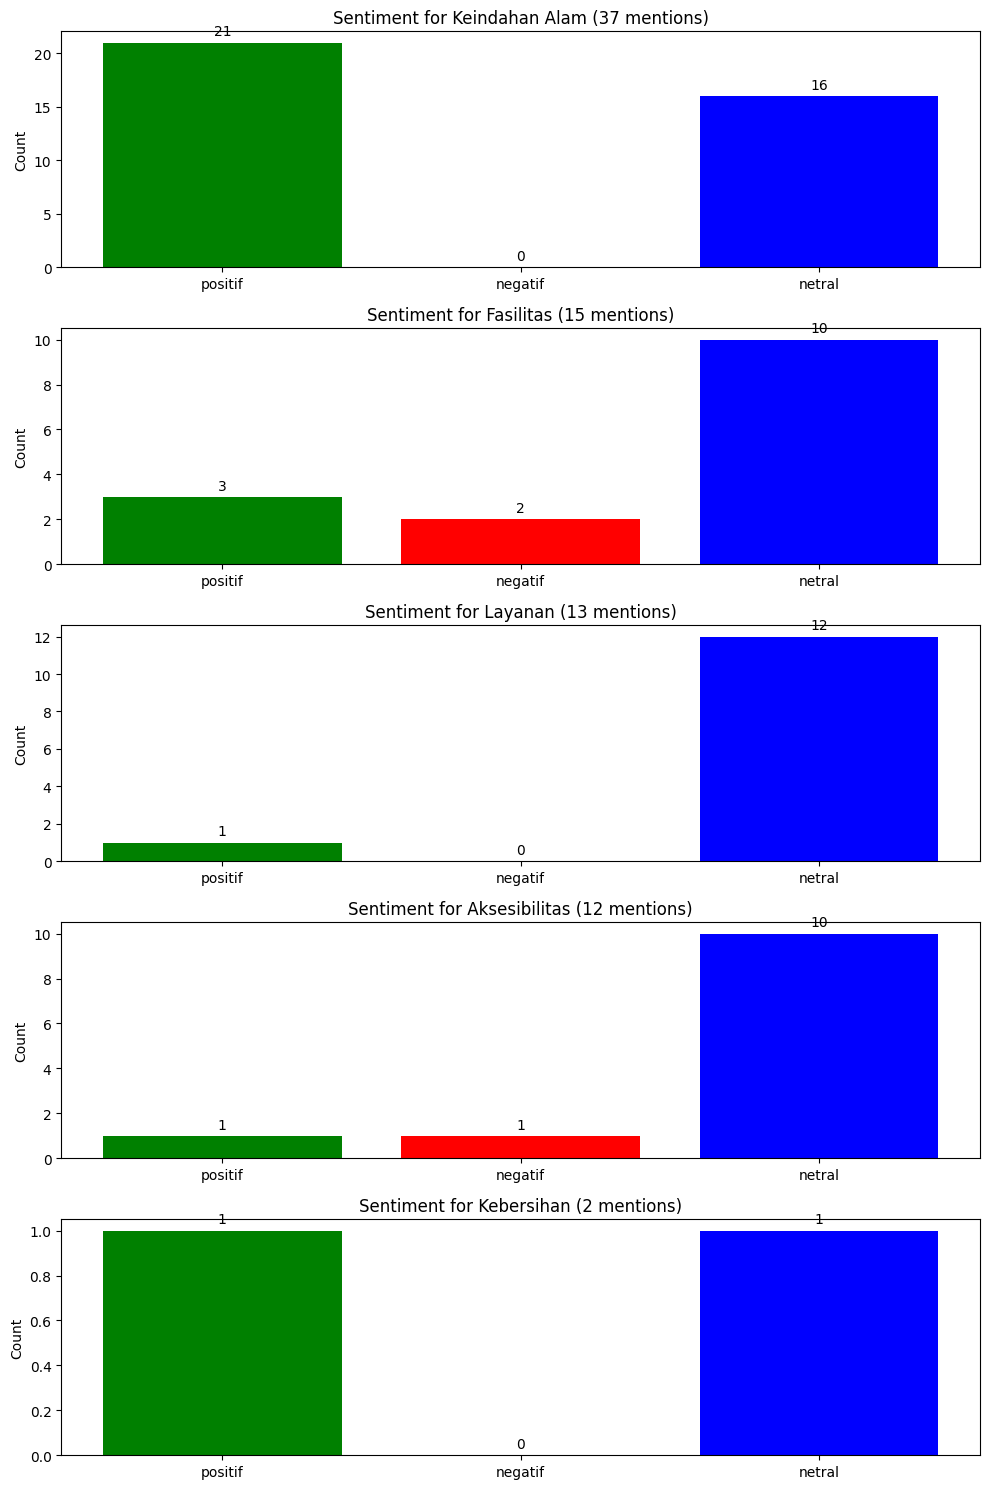

In [43]:
fig, axes = plt.subplots(len(aspects), 1, figsize=(10, 3*len(aspects)))

for i, (aspect, count) in enumerate(sorted_aspects):
    sentiments = aspect_sentiments[aspect]
    labels = list(sentiments.keys())
    values = list(sentiments.values())
    
    ax = axes[i] if len(aspects) > 1 else axes
    bars = ax.bar(labels, values, color=['green', 'red', 'blue'])
    ax.set_title(f'Sentiment for {aspect.replace("_", " ").title()} ({count} mentions)')
    ax.set_ylabel('Count')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig('aspect_sentiments.png')
plt.show()


In [44]:
def find_representative_comments(df, aspect_name, sentiment):
    """Find representative comments for a specific aspect and sentiment based on confidence score"""
    representative_comments = []
    
    for index, row in df.iterrows():
        aspects = row['enhanced_aspects']
        if isinstance(aspects, dict) and aspect_name in aspects:
            if aspects[aspect_name]['sentiment'] == sentiment:
                confidence = aspects[aspect_name]['confidence']
                representative_comments.append((row['content'], confidence, index))
    
    # Sort by confidence score (highest confidence first)
    sorted_comments = sorted(representative_comments, key=lambda x: x[1], reverse=True)
    return [(comment, conf, idx) for comment, conf, idx in sorted_comments[:3]]

# Define function to print comments in a nice format
def print_comment_details(comment, confidence, index, num):
    """Print a comment with details in a readable format"""
    # Truncate long comments for display purposes
    display_comment = comment[:100] + "..." if len(comment) > 100 else comment
    print(f"{num}. {display_comment}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"   Index: {index}")
    print()

# Get the top aspect from sorted aspects
top_aspect = sorted_aspects[0][0] if sorted_aspects else 'keindahan_alam'

# Get representative comments for Keindahan Alam aspect specifically
print("\n=== Representative Comments for Keindahan Alam ===")

# Ensure we analyze Keindahan Alam even if it's not the top aspect
keindahan_aspect = 'keindahan_alam'
keindahan_count = aspect_mentions.get(keindahan_aspect, 0)
print(f"Aspect 'Keindahan Alam' has {keindahan_count} mentions")

for sentiment in ['positif', 'negatif', 'netral']:
    comments = find_representative_comments(df_analysis, keindahan_aspect, sentiment)
    if comments:
        print(f"\n🔹 {sentiment.upper()} Comments:")
        for i, (comment, confidence, idx) in enumerate(comments, 1):
            print_comment_details(comment, confidence, idx, i)
    else:
        print(f"\n🔹 No {sentiment.upper()} Comments found for Keindahan Alam")

# Print the original top aspect data too (which may be different than Keindahan Alam)
if top_aspect != keindahan_aspect:
    print(f"\n=== Representative Comments for {top_aspect.replace('_', ' ').title()} (Most Mentioned Aspect) ===")
    print(f"Aspect '{top_aspect.replace('_', ' ').title()}' has {sorted_aspects[0][1]} mentions")
    
    for sentiment in ['positif', 'negatif', 'netral']:
        comments = find_representative_comments(df_analysis, top_aspect, sentiment)
        if comments:
            print(f"\n🔹 {sentiment.upper()} Comments:")
            for i, (comment, confidence, idx) in enumerate(comments, 1):
                print_comment_details(comment, confidence, idx, i)
        else:
            print(f"\n🔹 No {sentiment.upper()} Comments found for {top_aspect.replace('_', ' ').title()}")

# Summary statistics
print("\n=== Summary of Sentiment Analysis ===")
print(f"📊 Total comments analyzed: {len(df_analysis)}")
print(f"📈 Overall sentiment distribution:")
print(f"   • Positif: {positive_count} comments ({positive_count/len(df_analysis):.1%})")
print(f"   • Negatif: {negative_count} comments ({negative_count/len(df_analysis):.1%})")
print(f"   • Netral: {neutral_count} comments ({neutral_count/len(df_analysis):.1%})")

# Show top 3 aspects
print("\n🔝 Top 3 discussed aspects:")
for i, (aspect, count) in enumerate(sorted_aspects[:3], 1):
    print(f"   {i}. {aspect.replace('_', ' ').title()}: {count} mentions ({count/len(df_analysis):.1%})")


=== Representative Comments for Keindahan Alam ===
Aspect 'Keindahan Alam' has 37 mentions

🔹 POSITIF Comments:
1. Mantab sekali view giliran labak
   Confidence: 95.00%
   Index: 3

2. Keren sekali mas
   Confidence: 95.00%
   Index: 5

3. Wah bagus banget tempatnya ??
   Confidence: 95.00%
   Index: 9


🔹 No NEGATIF Comments found for Keindahan Alam

🔹 NETRAL Comments:
1. Bisa nginep di pulau gak?
   Confidence: 95.00%
   Index: 50

2. Di pulau itu ada sinyal ga bang?
   Confidence: 83.33%
   Index: 53

3. brp sewa kapalnya bang? ada penginapan enggak di pulau itu ?
   Confidence: 70.00%
   Index: 51


=== Summary of Sentiment Analysis ===
📊 Total comments analyzed: 172
📈 Overall sentiment distribution:
   • Positif: 35 comments (20.3%)
   • Negatif: 2 comments (1.2%)
   • Netral: 135 comments (78.5%)

🔝 Top 3 discussed aspects:
   1. Keindahan Alam: 37 mentions (21.5%)
   2. Fasilitas: 15 mentions (8.7%)
   3. Layanan: 13 mentions (7.6%)
